In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Test GPU computation
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("\nPerforming a test computation on GPU...")
    with tf.device('/GPU:0'):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        c = tf.matmul(a, b)
        print("Matrix multiplication result shape:", c.shape)
        print("GPU test successful!")
else:
    print("\nNo GPU available for computation.") 

TensorFlow version: 2.19.0
Num GPUs Available: 0
GPU Devices: []

No GPU available for computation.


In [1]:
# ✅ Check GPU availability
import tensorflow as tf
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))
print('TensorFlow version:', tf.__version__)
print('GPU name:', tf.config.list_physical_devices('GPU'))
print("GPU available:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 0
TensorFlow version: 2.19.0
GPU name: []
GPU available: []


In [2]:
# ✅ Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

In [3]:
# ✅ (Optional) Enable mixed precision for RTX 3060 Tensor Cores
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print('✅ Mixed precision policy set to:', mixed_precision.global_policy())

✅ Mixed precision policy set to: <DTypePolicy "mixed_float16">


# Facial Emotion Recognition Model

This notebook implements a deep learning model for facial emotion recognition using a CNN architecture. The model is trained on grayscale images of faces to classify emotions into 7 categories.

## Setup and Imports
First, let's import the necessary libraries for our project.

In [1]:
# Import required libraries
from keras.utils import to_categorical  # For one-hot encoding of labels
from keras_preprocessing.image import load_img  # For loading and preprocessing images
from keras.models import Sequential  # For creating the CNN model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D  # CNN layers
import os  # For file and directory operations
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## Data Directory Setup
Define the paths for training and testing data directories.

In [2]:
# Define data directories
TRAIN_DIR = 'images/train'  # Directory containing training images
TEST_DIR = 'images/test'    # Directory containing test images

## Data Loading Functions
Create a function to load image paths and their corresponding labels from the directories.

In [4]:
def createdataframe(dir):
    """
    Create a DataFrame containing image paths and their labels.
    
    Args:
        dir (str): Directory path containing emotion-labeled image folders
    
    Returns:
        tuple: Lists of image paths and their corresponding labels
    """
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir, label)):
            image_paths.append(os.path.join(dir, label, imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths, labels

## Load Training Data
Create a DataFrame for training data with image paths and labels.

In [5]:
# Create training DataFrame
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)
print(train)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
                                             image     label
0         images/train\angry\Training_10118481.jpg     angry
1         images/train\angry\Training_10120469.jpg     angry
2         images/train\angry\Training_10131352.jpg     angry
3         images/train\angry\Training_10161559.jpg     angry
4          images/train\angry\Training_1021836.jpg     angry
...                                            ...       ...
28704  images/train\surprise\Training_99916297.jpg  surprise
28705  images/train\surprise\Training_99924420.jpg  surprise
28706  images/train\surprise\Training_99937001.jpg  surprise
28707  images/train\surprise\Training_99951755.jpg  surprise
28708  images/train\surprise\Training_99984132.jpg  surprise

[28709 rows x 2 columns]


## Load Testing Data
Create a DataFrame for testing data with image paths and labels.

In [6]:
# Create testing DataFrame
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)
print(test)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
                                             image     label
0       images/test\angry\PrivateTest_10131363.jpg     angry
1       images/test\angry\PrivateTest_10304478.jpg     angry
2        images/test\angry\PrivateTest_1054527.jpg     angry
3       images/test\angry\PrivateTest_10590091.jpg     angry
4        images/test\angry\PrivateTest_1109992.jpg     angry
...                                            ...       ...
7173  images/test\surprise\PublicTest_98089595.jpg  surprise
7174  images/test\surprise\PublicTest_98567249.jpg  surprise
7175  images/test\surprise\PublicTest_98972870.jpg  surprise
7176  images/test\surprise\PublicTest_99242645.jpg  surprise
7177  images/test\surprise\PublicTest_99446963.jpg  surprise

[7178 rows x 2 columns]


## Feature Extraction
Import tqdm for progress bar visualization during feature extraction.

In [7]:
from tqdm.notebook import tqdm  # For progress bar visualization

### Image Preprocessing Function
Create a function to load and preprocess images into a format suitable for the model.

In [8]:
def extract_features(images):
    """
    Extract features from images by loading and preprocessing them.
    
    Args:
        images (list): List of image paths
    
    Returns:
        numpy.ndarray: Preprocessed image features
    """
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)  # Load image in grayscale
        img = np.array(img)  # Convert to numpy array
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Reshape for CNN input
    return features

### Extract Features from Images
Process both training and testing images.

In [9]:
# Extract features from training and test images
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

c:\Users\FERRA\OneDrive\Documents\Github\Facial-Emotions-Detection\venv\Lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


  0%|          | 0/7178 [00:00<?, ?it/s]

## Data Normalization
Normalize the pixel values to range between 0 and 1.

In [10]:
# Normalize pixel values to range [0,1]
x_train = train_features / 255.0
x_test = test_features / 255.0

## Label Encoding
Convert emotion labels to one-hot encoded format for model training.

In [11]:
# Encode labels and convert to one-hot format
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])
y_train = to_categorical(y_train, num_classes=7)  # Convert to one-hot encoding
y_test = to_categorical(y_test, num_classes=7)    # Convert to one-hot encoding

## Model Architecture
Create a CNN model with multiple convolutional layers, pooling layers, and fully connected layers.

In [22]:
# Create sequential model
model = Sequential()


In [23]:
# First convolutional block
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

In [24]:
# Second convolutional block
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


In [25]:
# Third convolutional block
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

In [26]:
# Fourth convolutional block
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

In [27]:
# Flatten layer to convert 2D features to 1D
model.add(Flatten())

In [28]:
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

In [29]:
# Output layer with softmax activation for 7 emotion classes
model.add(Dense(7, activation='softmax'))

In [30]:

# Compile model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Model Training
Train the model on the prepared dataset.

In [31]:
# Train the model
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 216s 949ms/step - accuracy: 0.2436 - loss: 1.8377 - val_accuracy: 0.2471 - val_loss: 1.8182
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 214s 951ms/step - accuracy: 0.2515 - loss: 1.8129 - val_accuracy: 0.2581 - val_loss: 1.7924
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 223s 989ms/step - accuracy: 0.2642 - loss: 1.7763 - val_accuracy: 0.3061 - val_loss: 1.6754
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 216s 962ms/step - accuracy: 0.3113 - loss: 1.6852 - val_accuracy: 0.4126 - val_loss: 1.4943
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 218s 968ms/step - accuracy: 0.3878 - loss: 1.5542 - val_accuracy: 0.4585 - val_loss: 1.4216
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 223s 989ms/step - accuracy: 0.4280 - loss: 1.4640 - val_accuracy: 0.4902 - val_loss: 1.3316
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 214s 950ms/step - accuracy: 0.4537 - loss: 1.4146 - val_accuracy: 0.4937 - val_loss: 1.2993
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 920ms/step - accuracy: 

## Save Model
Save the trained model and its architecture for future use.

In [32]:
# Save model architecture to JSON file
model_json = model.to_json()
with open("emotiondetector.json", 'w') as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
model.save("emotiondetector.h5")

In [6]:
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
json_file = open("emotiondetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("emotiondetector.h5")

In [7]:
label = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Prétraitement d'image
def ef(image):
    img = load_img(image, color_mode='grayscale', target_size=(48, 48))
    feature = img_to_array(img)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0


In [8]:
# Tester sur une image
image = 'images/train/sad/Training_2913.jpg'
print("Original image is: sad 😢")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("Model prediction is:", pred_label)

Original image is: sad 😢
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Model prediction is: sad


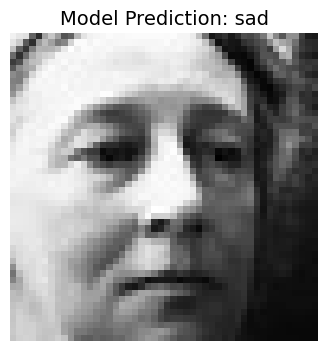

In [11]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

# Affichage image et prédiction
plt.figure(figsize=(4, 4))
img_display = load_img(image, color_mode='grayscale')
plt.imshow(img_display, cmap='gray')
plt.title(f"Model Prediction: {pred_label}", fontsize=14)
plt.axis('off')
plt.show()

In [44]:
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model_accuracy(n=100, show_conf_matrix=True):
    base_dir = 'images/train'
    emotion_classes = os.listdir(base_dir)
    correct = 0
    total = 0

    y_true = []
    y_pred = []

    for i in range(n):
        true_label = random.choice(emotion_classes)
        image_list = os.listdir(os.path.join(base_dir, true_label))
        image_name = random.choice(image_list)
        image_path = os.path.join(base_dir, true_label, image_name)

        try:
            img = ef(image_path)
            prediction = model.predict(img)
            predicted_label = label[prediction.argmax()]

            y_true.append(true_label)
            y_pred.append(predicted_label)

            if predicted_label == true_label:
                correct += 1
            total += 1

        except Exception as e:
            print(f"⚠️ Error with image {image_name}: {e}")
            continue

    incorrect = total - correct
    accuracy = correct / total * 100

    # Print summary
    print(f"\n✅ Tested {total} random images")
    print(f"✅ Correct predictions: {correct}")
    print(f"❌ Incorrect predictions: {incorrect}")
    print(f"📊 Model accuracy: {accuracy:.2f}%")

    # Bar chart of correct vs incorrect
    plt.figure(figsize=(6, 4))
    plt.bar(['Correct', 'Incorrect'], [correct, incorrect], color=['green', 'red'])
    plt.title("Prediction Results")
    plt.ylabel("Number of Predictions")
    plt.grid(axis='y')
    plt.show()

    # Optional: Confusion matrix
    if show_conf_matrix:
        cm = confusion_matrix(y_true, y_pred, labels=label)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
        plt.figure(figsize=(8, 6))
        disp.plot(cmap='Blues', xticks_rotation=45)
        plt.title("Confusion Matrix on Random Images")
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

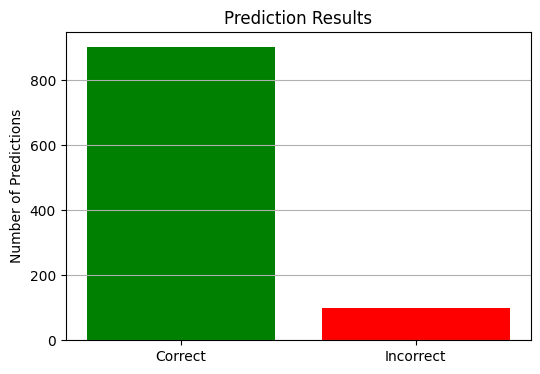

<Figure size 800x600 with 0 Axes>

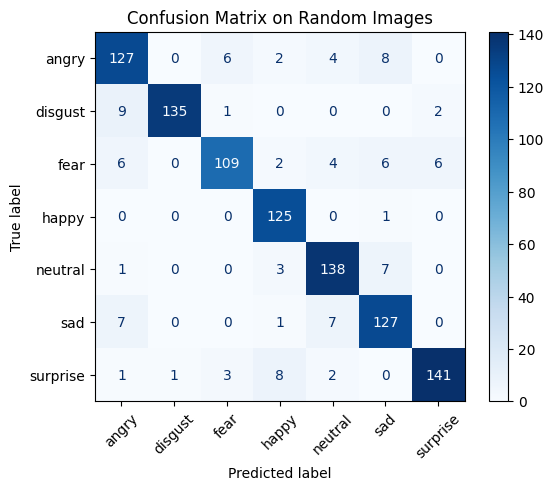

In [46]:
test_model_accuracy(n=1000)